In [ ]:
# 03_analysis_visuals.ipynb
# **Project:** Pedestrian Corridor Analysis — Analysis & Visualizations
# **Purpose:** Load cleaned combined dataset, produce summary tables, compare pedestrian counts vs corridor demand categories, borough breakdowns, identify outliers and alignment issues, and save dashboard-ready CSVs/figures.


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)

# Load cleaned CSV / GeoJSON (from previous notebook)
csv_path = "../data_clean/pedestrian_combined.csv"
geo_path = "../data_clean/pedestrian_combined.geojson"

df = pd.read_csv(csv_path)
print("Loaded CSV shape:", df.shape)
display(df.head())

# If geojson exists and you want mapping later:
try:
    gdf = gpd.read_file(geo_path)
    print("Loaded GeoJSON shape:", gdf.shape)
except Exception as e:
    print("GeoJSON not loaded:", e)
    gdf = None


Loaded CSV shape: (155, 9)


,OBJECTID,Loc,Borough,Street_Nam_clean,avg_recent_count,segmentid,street_clean,Category,dist_m
0,1,1,Bronx,BROADWAY,2138.555556,79707,BROADWAY,Regional,0.125303
1,2,2,Bronx,EAST 161ST STREET,2964.555556,313939,EAST 161 STREET,Regional,1.417309
2,3,3,Bronx,EAST FORDHAM ROAD,4018.111111,80043,EAST FORDHAM ROAD,Regional,1.110133
3,4,4,Bronx,EAST GUN HILL ROAD,1535.777778,81299,EAST GUN HILL ROAD,Neighborhood,0.835461
4,5,5,Bronx,EAST TREMONT AVENUE,1370.111111,78822,EAST TREMONT AVENUE,Regional,0.329976


Loaded GeoJSON shape: (155, 228)


### Analysis goals
- Produce summary statistics by **Category** (Baseline → Global) and **Borough**.  
- Visualize average pedestrian counts by Category (bar, boxplot).  
- Produce borough breakdowns and maps (if GeoJSON available).  
- Identify outliers (very high or very low counts) and sites with poor category alignment.  
- Export summary tables for dashboard (CSV)

In [4]:
# Ensure avg_recent_count numeric
df['avg_recent_count'] = pd.to_numeric(df['avg_recent_count'], errors='coerce')

# Basic summary by Category
cat_summary = df.groupby('Category')['avg_recent_count'].agg(['count','mean','median','std','min','max']).reset_index().sort_values('mean', ascending=False)
display(cat_summary)

# Save
cat_summary.to_csv('summary_by_category.csv', index=False)
print("Saved summary_by_category.csv")


,Category,count,mean,median,std,min,max
1,Global,50,5996.902222,5332.444444,2466.141964,1632.222222,13352.333333
3,Regional,30,2536.229630,2193.111111,1495.628510,0.000000,8375.111111
2,Neighborhood,57,1456.662768,1243.444444,1093.413556,61.000000,3712.666667
0,Community,18,737.530864,282.388889,1210.439397,0.000000,3974.111111


Saved summary_by_category.csv


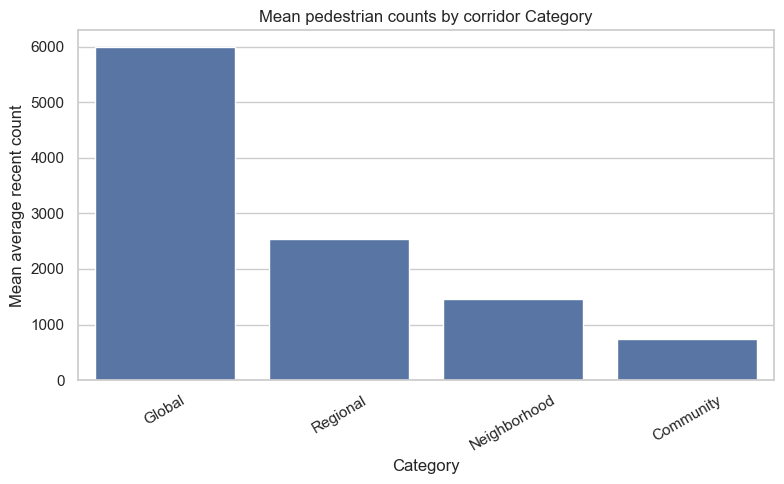

In [5]:
order = cat_summary.sort_values('mean', ascending=False)['Category'].tolist()

plt.figure(figsize=(8,5))
sns.barplot(data=cat_summary, x='Category', y='mean', order=order)
plt.ylabel('Mean average recent count')
plt.title('Mean pedestrian counts by corridor Category')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


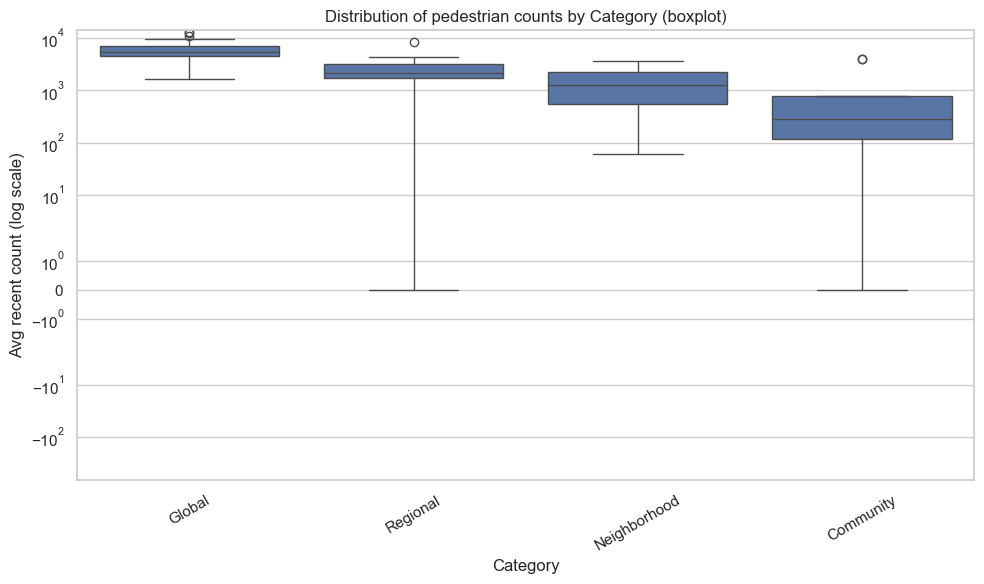

In [7]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Category', y='avg_recent_count', order=order)
plt.yscale('symlog')  # optional: helps show wide ranges (comment out if not desired)
plt.title('Distribution of pedestrian counts by Category (boxplot)')
plt.xlabel('Category')
plt.ylabel('Avg recent count (log scale)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


Category,Community,Global,Neighborhood,Regional
Borough,,,,
Bronx,0.000000,0.000000,2371.777778,2293.955556
Brooklyn,428.333333,2986.611111,2130.303704,2379.044444
East River Bridges,2383.277778,0.000000,283.703704,0.000000
Harlem River Bridges,129.523810,0.000000,360.396825,0.000000
Manhattan,769.444444,6148.721040,2481.166667,2571.222222
Queens,122.000000,4882.000000,1684.979167,2853.513889
Staten Isla,248.851852,0.000000,666.481481,0.000000


borough_category_pivot.csv


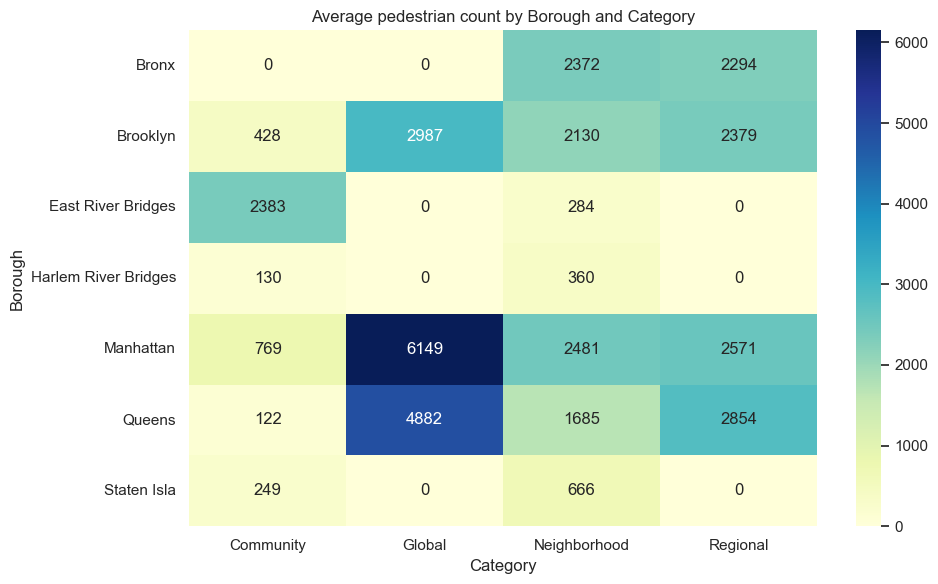

In [9]:
# Borough handling - ensure column present
borough_col = 'Borough' if 'Borough' in df.columns else ('BoroName' if 'BoroName' in df.columns else None)
if not borough_col:
    print("No borough column found; add a borough column first.")
else:
    pivot = df.pivot_table(index=borough_col, columns='Category', values='avg_recent_count', aggfunc='mean').fillna(0)
    display(pivot)
    pivot.to_csv('borough_category_pivot.csv')
    print("borough_category_pivot.csv")

    # Heatmap
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title('Average pedestrian count by Borough and Category')
    plt.ylabel('Borough')
    plt.xlabel('Category')
    plt.tight_layout()
    plt.show()


Category,Community,Global,Neighborhood,Regional
Borough,,,,
Bronx,0.000000,0.000000,2371.777778,2293.955556
Brooklyn,428.333333,2986.611111,2130.303704,2379.044444
East River Bridges,2383.277778,0.000000,283.703704,0.000000
Harlem River Bridges,129.523810,0.000000,360.396825,0.000000
Manhattan,769.444444,6148.721040,2481.166667,2571.222222
Queens,122.000000,4882.000000,1684.979167,2853.513889
Staten Isla,248.851852,0.000000,666.481481,0.000000


Saved borough_category_pivot.csv


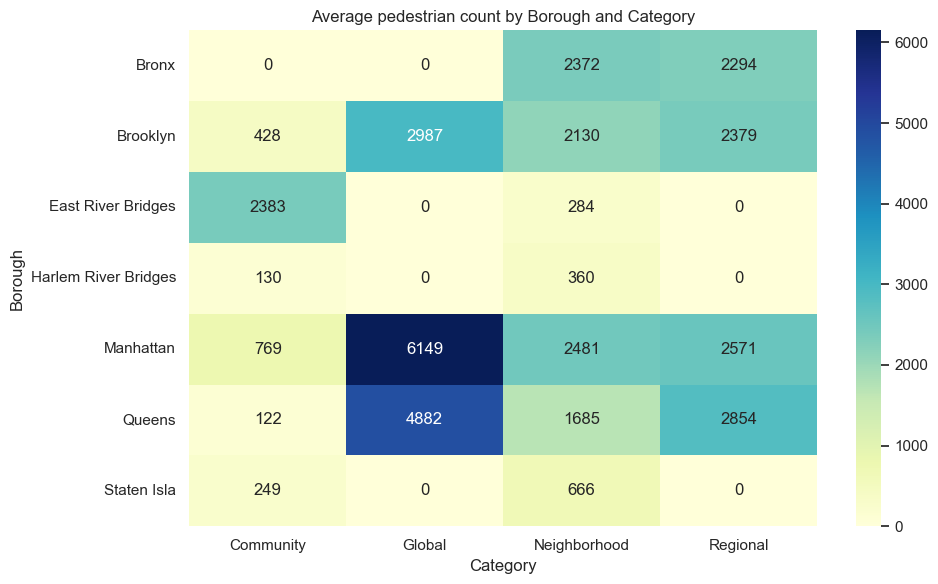

In [11]:
# Borough handling - ensure column present
borough_col = 'Borough' if 'Borough' in df.columns else ('BoroName' if 'BoroName' in df.columns else None)
if not borough_col:
    print("No borough column found; add a borough column first.")
else:
    pivot = df.pivot_table(index=borough_col, columns='Category', values='avg_recent_count', aggfunc='mean').fillna(0)
    display(pivot)
    pivot.to_csv('borough_category_pivot.csv')
    print("Saved borough_category_pivot.csv")

    # Heatmap
    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
    plt.title('Average pedestrian count by Borough and Category')
    plt.ylabel('Borough')
    plt.xlabel('Category')
    plt.tight_layout()
    plt.show()


In [12]:
# Example heuristic: define expected rank thresholds (customize)
# If corridor Category is ordinal, map to numeric rank (sample mapping)
rank_map = {
    'Global': 5,
    'Regional': 4,
    'City': 3,
    'Community': 2,
    'Baseline': 1
}
# If your Category names differ, adjust above map.

df['Category_rank'] = df['Category'].map(rank_map)
# Compute quantile-based rank of counts (1-5)
df['count_rank'] = pd.qcut(df['avg_recent_count'].rank(method='first', na_option='bottom'), 5, labels=[1,2,3,4,5]).astype(float)

# Alignment metric: difference
df['alignment_diff'] = df['count_rank'].astype(float) - df['Category_rank'].astype(float)

# Flag big mismatches (e.g., abs(diff) >=2)
df['alignment_flag'] = df['alignment_diff'].abs() >= 2

display(df[['OBJECTID','Loc','Street_Nam_clean','Category','Category_rank','avg_recent_count','count_rank','alignment_diff','alignment_flag']].sort_values('alignment_diff', ascending=False).head(20))

# Save mismatches for review
df[df['alignment_flag']].to_csv('alignment_mismatches.csv', index=False)
print("Saved alignment_mismatches.csv (sites with large mismatch)")


,OBJECTID,Loc,Street_Nam_clean,Category,Category_rank,avg_recent_count,count_rank,alignment_diff,alignment_flag
128,101,101,BROOKLYN BRIDGE,Community,2.0,3974.111111,4.0,2.0,True
129,101,101,BROOKLYN BRIDGE,Community,2.0,3974.111111,4.0,2.0,True
118,92,92,ROOSEVELT AVENUE,Regional,4.0,8375.111111,5.0,1.0,False
68,54,54,WEST 125TH STREET,Global,5.0,5332.444444,5.0,0.0,False
95,70,70,HUDSON RIVER GREENWAY,Community,2.0,769.444444,2.0,0.0,False
94,70,70,HUDSON RIVER GREENWAY,Community,2.0,769.444444,2.0,0.0,False
59,51,51,SEVENTH AVENUE,Global,5.0,9353.000000,5.0,0.0,False
60,51,51,SEVENTH AVENUE,Global,5.0,9353.000000,5.0,0.0,False
61,51,51,SEVENTH AVENUE,Global,5.0,9353.000000,5.0,0.0,False
93,69,69,EIGHTH AVENUE,Global,5.0,6995.222222,5.0,0.0,False


Saved alignment_mismatches.csv (sites with large mismatch)


In [13]:
# If you have year-specific columns in original counts (many columns), you can compute per-year averages.
# We attempt to detect per-year numeric columns from original DataFrame (look for '24','23','22' in col names)
year_cols = [c for c in df.columns if any(y in c for y in ['24','23','22','21','20','19','18'])]
# Filter to numeric ones
year_num_cols = [c for c in year_cols if df[c].dtype in [int,float] or pd.to_numeric(df[c], errors='coerce').notna().any()]

print("Detected possible year columns (sample):", year_num_cols[:20])

# If you have such columns, reshape to long and compute per-year mean (this block is optional and may require editing)
if year_num_cols:
    # extract year from col name heuristically (two digits)
    def col_to_year(col):
        import re
        m = re.search(r'(\d{2})', col)
        if m:
            two = int(m.group(1))
            return 2000 + two
        return None
    long = df.melt(id_vars=['OBJECTID','Loc','Borough','Street_Nam_clean','Category'], value_vars=year_num_cols,
                   var_name='col', value_name='count_val')
    long['count_val'] = pd.to_numeric(long['count_val'], errors='coerce')
    long['year'] = long['col'].apply(col_to_year)
    # per-year mean
    year_trend = long.groupby('year')['count_val'].mean().reset_index().dropna()
    display(year_trend)
    plt.figure(figsize=(8,4))
    sns.lineplot(data=year_trend, x='year', y='count_val', marker='o')
    plt.title('Citywide average count trend')
    plt.ylabel('Mean count')
    plt.show()
else:
    print("No obvious per-year numeric columns detected in this cleaned file. If you need per-year trends, run on the raw counts file before aggregation.")


Detected possible year columns (sample): []
No obvious per-year numeric columns detected in this cleaned file. If you need per-year trends, run on the raw counts file before aggregation.


In [15]:
# Top 10 by avg_recent_count
topn = df.sort_values('avg_recent_count', ascending=False).head(20)
display(topn[['OBJECTID','Loc','Street_Nam_clean','Category','avg_recent_count','segmentid','street_clean']])

topn[['OBJECTID','Loc','Street_Nam_clean','Category','avg_recent_count','segmentid','street_clean']].to_csv('top_sites.csv', index=False)
print("Saved output/top_sites.csv")


,OBJECTID,Loc,Street_Nam_clean,Category,avg_recent_count,segmentid,street_clean
76,57,57,WEST 34TH STREET,Global,13352.333333,297778,WEST 34 STREET
51,44,44,EIGHTH AVENUE,Global,12592.777778,33957,8 AVENUE
87,65,65,FIFTH AVENUE,Global,10745.444444,35843,5 AVENUE
89,66,66,SIXTH AVENUE,Global,9698.777778,34211,AVENUE OF THE AMERICAS
88,66,66,SIXTH AVENUE,Global,9698.777778,34211,AVENUE OF THE AMERICAS
61,51,51,SEVENTH AVENUE,Global,9353.000000,33809,7 AVENUE
60,51,51,SEVENTH AVENUE,Global,9353.000000,33809,7 AVENUE
59,51,51,SEVENTH AVENUE,Global,9353.000000,33809,7 AVENUE
52,45,45,FIFTH AVENUE,Global,8647.222222,35994,5 AVENUE
118,92,92,ROOSEVELT AVENUE,Regional,8375.111111,91198,ROOSEVELT AVENUE


Saved output/top_sites.csv


In [16]:
# 1) Full table for dashboard (lightweight)
dashboard_table = df[['OBJECTID','Loc','Borough','Street_Nam_clean','avg_recent_count','segmentid','street_clean','Category','dist_m']].copy()
dashboard_table.to_csv('dashboard_table.csv', index=False)
print("Saved dashboard_table.csv (for dashboard ingestion)")

# 2) Aggregations
agg_by_borough = df.groupby('Borough')['avg_recent_count'].agg(['count','mean','median']).reset_index()
agg_by_borough.to_csv('agg_by_borough.csv', index=False)
print("Saved agg_by_borough.csv")


Saved dashboard_table.csv (for dashboard ingestion)
Saved agg_by_borough.csv


## Next steps & notes

- Review `output/alignment_mismatches.csv` and `output/top_sites.csv`. Decide if mismatches require manual correction or method changes.
- If many sites are unmatched or flagged, consider fuzzy street-name matching (thefuzz) or expanding spatial search distance.
- Once finalized, load `output/dashboard_table.csv` into SQL Server (or have backend read this CSV) for dashboard integration.
- Save key plots as PNGs if you want to embed them in the presentation (use `plt.savefig()`).
